In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

import os
import sys
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

import XAIRT
import XAIRT.backend as backend
from XAIRT.backend.graph import getLayerIndexByName

2023-06-28 20:21:17.936878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 20:21:18.173783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-28 20:21:18.173816: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ig

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

In [3]:
L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 10 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [4]:
keras.backend.clear_session()

inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(M_samples, H_samples,
            batch_size=10,
            epochs=1000, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-06-28 20:37:01.970932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-28 20:37:01.970998: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-28 20:37:01.971169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1-3): /proc/driver/nvidia/version does not exist
2023-06-28 20:37:01.971891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binar

680/800 [========================>.....] - ETA: 0s - loss: 8.6916e-04 - mae: 0.0239
Epoch 1: val_loss improved from inf to 0.00048, saving model to model.h5
800/800 [==============================] - 0s 417us/sample - loss: 8.1004e-04 - mae: 0.0231 - val_loss: 4.8225e-04 - val_mae: 0.0188
Epoch 2/1000
360/800 [============>.................] - ETA: 0s - loss: 4.4658e-04 - mae: 0.0180

2023-06-28 20:37:02.312589: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:88 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


730/800 [==========================>...] - ETA: 0s - loss: 4.5057e-04 - mae: 0.0181
Epoch 2: val_loss did not improve from 0.00048
800/800 [==============================] - 0s 163us/sample - loss: 4.6192e-04 - mae: 0.0183 - val_loss: 5.0263e-04 - val_mae: 0.0195
Epoch 3/1000
800/800 [==============================] - ETA: 0s - loss: 4.5456e-04 - mae: 0.0182
Epoch 3: val_loss improved from 0.00048 to 0.00046, saving model to model.h5
800/800 [==============================] - 0s 175us/sample - loss: 4.5456e-04 - mae: 0.0182 - val_loss: 4.6155e-04 - val_mae: 0.0183
Epoch 4/1000
730/800 [==========================>...] - ETA: 0s - loss: 4.4846e-04 - mae: 0.0181
Epoch 4: val_loss improved from 0.00046 to 0.00045, saving model to model.h5
800/800 [==============================] - 0s 185us/sample - loss: 4.3966e-04 - mae: 0.0179 - val_loss: 4.5278e-04 - val_mae: 0.0182
Epoch 5/1000
740/800 [==========================>...] - ETA: 0s - loss: 4.2040e-04 - mae: 0.0175
Epoch 5: val_loss did not

750/800 [===========================>..] - ETA: 0s - loss: 6.9529e-05 - mae: 0.0067
Epoch 29: val_loss did not improve from 0.00015
800/800 [==============================] - 0s 161us/sample - loss: 7.0595e-05 - mae: 0.0068 - val_loss: 1.5192e-04 - val_mae: 0.0104
Epoch 30/1000
790/800 [============================>.] - ETA: 0s - loss: 7.1964e-05 - mae: 0.0068
Epoch 30: val_loss improved from 0.00015 to 0.00013, saving model to model.h5
800/800 [==============================] - 0s 178us/sample - loss: 7.1880e-05 - mae: 0.0068 - val_loss: 1.3163e-04 - val_mae: 0.0093
Epoch 31/1000
800/800 [==============================] - ETA: 0s - loss: 6.7261e-05 - mae: 0.0066
Epoch 31: val_loss improved from 0.00013 to 0.00012, saving model to model.h5
800/800 [==============================] - 0s 180us/sample - loss: 6.7261e-05 - mae: 0.0066 - val_loss: 1.2119e-04 - val_mae: 0.0090
Epoch 32/1000
780/800 [============================>.] - ETA: 0s - loss: 6.5036e-05 - mae: 0.0065
Epoch 32: val_loss 

420/800 [==============>...............] - ETA: 0s - loss: 2.7678e-05 - mae: 0.0042
Epoch 56: val_loss improved from 0.00005 to 0.00005, saving model to model.h5
800/800 [==============================] - 0s 171us/sample - loss: 2.4865e-05 - mae: 0.0040 - val_loss: 5.1384e-05 - val_mae: 0.0057
Epoch 57/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.3123e-05 - mae: 0.0039
Epoch 57: val_loss improved from 0.00005 to 0.00005, saving model to model.h5
800/800 [==============================] - 0s 193us/sample - loss: 2.2617e-05 - mae: 0.0038 - val_loss: 5.1210e-05 - val_mae: 0.0057
Epoch 58/1000
710/800 [=========================>....] - ETA: 0s - loss: 2.3448e-05 - mae: 0.0039
Epoch 58: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 169us/sample - loss: 2.3865e-05 - mae: 0.0039 - val_loss: 5.4160e-05 - val_mae: 0.0059
Epoch 59/1000
790/800 [============================>.] - ETA: 0s - loss: 2.4378e-05 - mae: 0.0040
Epoch 59: val_loss 

790/800 [============================>.] - ETA: 0s - loss: 1.8148e-05 - mae: 0.0034
Epoch 84: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 153us/sample - loss: 1.8252e-05 - mae: 0.0034 - val_loss: 4.7191e-05 - val_mae: 0.0055
Epoch 85/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6872e-05 - mae: 0.0034
Epoch 85: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 146us/sample - loss: 1.9257e-05 - mae: 0.0035 - val_loss: 4.8805e-05 - val_mae: 0.0057
Epoch 86/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8874e-05 - mae: 0.0035
Epoch 86: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 148us/sample - loss: 2.0654e-05 - mae: 0.0036 - val_loss: 5.9632e-05 - val_mae: 0.0060
Epoch 87/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.9812e-05 - mae: 0.0035
Epoch 87: val_loss did not improve from 0.00005
800/800 [======================

420/800 [==============>...............] - ETA: 0s - loss: 1.8766e-05 - mae: 0.0034
Epoch 113: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.9678e-05 - mae: 0.0035 - val_loss: 5.1138e-05 - val_mae: 0.0056
Epoch 114/1000
800/800 [==============================] - ETA: 0s - loss: 1.9966e-05 - mae: 0.0036
Epoch 114: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.9966e-05 - mae: 0.0036 - val_loss: 4.5593e-05 - val_mae: 0.0055
Epoch 115/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8795e-05 - mae: 0.0035
Epoch 115: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.8701e-05 - mae: 0.0035 - val_loss: 4.5757e-05 - val_mae: 0.0055
Epoch 116/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7358e-05 - mae: 0.0034
Epoch 116: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.9447e-05 - mae: 0.0036
Epoch 142: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8643e-05 - mae: 0.0035 - val_loss: 4.6397e-05 - val_mae: 0.0056
Epoch 143/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8914e-05 - mae: 0.0035
Epoch 143: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.8878e-05 - mae: 0.0035 - val_loss: 4.7632e-05 - val_mae: 0.0057
Epoch 144/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8528e-05 - mae: 0.0035
Epoch 144: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.8500e-05 - mae: 0.0035 - val_loss: 4.7753e-05 - val_mae: 0.0055
Epoch 145/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.8590e-05 - mae: 0.0035
Epoch 145: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 2.1670e-05 - mae: 0.0037
Epoch 171: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 2.1207e-05 - mae: 0.0037 - val_loss: 5.5242e-05 - val_mae: 0.0062
Epoch 172/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8651e-05 - mae: 0.0035
Epoch 172: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.0642e-05 - mae: 0.0037 - val_loss: 5.3424e-05 - val_mae: 0.0061
Epoch 173/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.1286e-05 - mae: 0.0037
Epoch 173: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 2.0341e-05 - mae: 0.0036 - val_loss: 5.2715e-05 - val_mae: 0.0056
Epoch 174/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8276e-05 - mae: 0.0034
Epoch 174: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7296e-05 - mae: 0.0034
Epoch 200: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.7389e-05 - mae: 0.0034 - val_loss: 5.8416e-05 - val_mae: 0.0059
Epoch 201/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8063e-05 - mae: 0.0034
Epoch 201: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.8291e-05 - mae: 0.0034 - val_loss: 4.6758e-05 - val_mae: 0.0055
Epoch 202/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8899e-05 - mae: 0.0034
Epoch 202: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.9070e-05 - mae: 0.0035 - val_loss: 4.8696e-05 - val_mae: 0.0055
Epoch 203/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8305e-05 - mae: 0.0034
Epoch 203: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.0228e-05 - mae: 0.0036
Epoch 229: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9139e-05 - mae: 0.0035 - val_loss: 5.1823e-05 - val_mae: 0.0060
Epoch 230/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9415e-05 - mae: 0.0035
Epoch 230: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.9559e-05 - mae: 0.0035 - val_loss: 5.7625e-05 - val_mae: 0.0058
Epoch 231/1000
800/800 [==============================] - ETA: 0s - loss: 1.8512e-05 - mae: 0.0035
Epoch 231: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.8512e-05 - mae: 0.0035 - val_loss: 4.8770e-05 - val_mae: 0.0058
Epoch 232/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7766e-05 - mae: 0.0034
Epoch 232: val_loss did not improve from 0.00004
800/800 [===============

730/800 [==========================>...] - ETA: 0s - loss: 1.7647e-05 - mae: 0.0033
Epoch 258: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.7665e-05 - mae: 0.0033 - val_loss: 4.8541e-05 - val_mae: 0.0058
Epoch 259/1000
800/800 [==============================] - ETA: 0s - loss: 1.8924e-05 - mae: 0.0035
Epoch 259: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.8924e-05 - mae: 0.0035 - val_loss: 4.7939e-05 - val_mae: 0.0055
Epoch 260/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.7828e-05 - mae: 0.0034
Epoch 260: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.8215e-05 - mae: 0.0034 - val_loss: 4.8195e-05 - val_mae: 0.0057
Epoch 261/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8036e-05 - mae: 0.0034
Epoch 261: val_loss did not improve from 0.00004
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.8374e-05 - mae: 0.0034
Epoch 287: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.8331e-05 - mae: 0.0034 - val_loss: 5.8281e-05 - val_mae: 0.0059
Epoch 288/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.9602e-05 - mae: 0.0035
Epoch 288: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.9730e-05 - mae: 0.0036 - val_loss: 4.7204e-05 - val_mae: 0.0056
Epoch 289/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1202e-05 - mae: 0.0037
Epoch 289: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 2.1090e-05 - mae: 0.0037 - val_loss: 4.6732e-05 - val_mae: 0.0055
Epoch 290/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.7840e-05 - mae: 0.0034
Epoch 290: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.7663e-05 - mae: 0.0033
Epoch 316: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.7663e-05 - mae: 0.0033 - val_loss: 4.7488e-05 - val_mae: 0.0057
Epoch 317/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6817e-05 - mae: 0.0032
Epoch 317: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7664e-05 - mae: 0.0034 - val_loss: 4.9051e-05 - val_mae: 0.0056
Epoch 318/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.7411e-05 - mae: 0.0034
Epoch 318: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.7578e-05 - mae: 0.0034 - val_loss: 4.7284e-05 - val_mae: 0.0057
Epoch 319/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7453e-05 - mae: 0.0034
Epoch 319: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.7542e-05 - mae: 0.0034
Epoch 345: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.8212e-05 - mae: 0.0034 - val_loss: 7.6364e-05 - val_mae: 0.0068
Epoch 346/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.2946e-05 - mae: 0.0039
Epoch 346: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.3298e-05 - mae: 0.0039 - val_loss: 4.6609e-05 - val_mae: 0.0056
Epoch 347/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6297e-05 - mae: 0.0032
Epoch 347: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8758e-05 - mae: 0.0035 - val_loss: 4.6665e-05 - val_mae: 0.0056
Epoch 348/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.7826e-05 - mae: 0.0034
Epoch 348: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.8594e-05 - mae: 0.0034
Epoch 374: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 2.0305e-05 - mae: 0.0036 - val_loss: 5.0617e-05 - val_mae: 0.0056
Epoch 375/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7775e-05 - mae: 0.0034
Epoch 375: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.9299e-05 - mae: 0.0035 - val_loss: 5.6478e-05 - val_mae: 0.0058
Epoch 376/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.8302e-05 - mae: 0.0035
Epoch 376: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.8064e-05 - mae: 0.0035 - val_loss: 4.7131e-05 - val_mae: 0.0055
Epoch 377/1000
680/800 [========================>.....] - ETA: 0s - loss: 2.0352e-05 - mae: 0.0036
Epoch 377: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.7192e-05 - mae: 0.0033
Epoch 403: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.7148e-05 - mae: 0.0033 - val_loss: 4.7610e-05 - val_mae: 0.0055
Epoch 404/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.0414e-05 - mae: 0.0036
Epoch 404: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.9952e-05 - mae: 0.0036 - val_loss: 5.3796e-05 - val_mae: 0.0061
Epoch 405/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9611e-05 - mae: 0.0036
Epoch 405: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.9444e-05 - mae: 0.0035 - val_loss: 4.6791e-05 - val_mae: 0.0056
Epoch 406/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.7358e-05 - mae: 0.0033
Epoch 406: val_loss did not improve from 0.00004
800/800 [===============

750/800 [===========================>..] - ETA: 0s - loss: 1.9830e-05 - mae: 0.0036
Epoch 432: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.9736e-05 - mae: 0.0036 - val_loss: 5.2974e-05 - val_mae: 0.0057
Epoch 433/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8480e-05 - mae: 0.0035
Epoch 433: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.9099e-05 - mae: 0.0035 - val_loss: 4.6895e-05 - val_mae: 0.0056
Epoch 434/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7329e-05 - mae: 0.0034
Epoch 434: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8796e-05 - mae: 0.0035 - val_loss: 4.8710e-05 - val_mae: 0.0056
Epoch 435/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.9555e-05 - mae: 0.0035
Epoch 435: val_loss did not improve from 0.00004
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.9978e-05 - mae: 0.0036
Epoch 461: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.9479e-05 - mae: 0.0035 - val_loss: 4.7008e-05 - val_mae: 0.0056
Epoch 462/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8452e-05 - mae: 0.0034
Epoch 462: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.8501e-05 - mae: 0.0034 - val_loss: 4.7068e-05 - val_mae: 0.0056
Epoch 463/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8216e-05 - mae: 0.0034
Epoch 463: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.7754e-05 - mae: 0.0034 - val_loss: 4.7444e-05 - val_mae: 0.0056
Epoch 464/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9023e-05 - mae: 0.0035
Epoch 464: val_loss did not improve from 0.00004
800/800 [===============

710/800 [=========================>....] - ETA: 0s - loss: 1.7491e-05 - mae: 0.0034
Epoch 490: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 1.7538e-05 - mae: 0.0034 - val_loss: 6.1474e-05 - val_mae: 0.0066
Epoch 491/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.0871e-05 - mae: 0.0036
Epoch 491: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 2.0928e-05 - mae: 0.0036 - val_loss: 4.7215e-05 - val_mae: 0.0057
Epoch 492/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.9889e-05 - mae: 0.0036
Epoch 492: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 2.0267e-05 - mae: 0.0036 - val_loss: 5.2629e-05 - val_mae: 0.0060
Epoch 493/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7809e-05 - mae: 0.0034
Epoch 493: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.5933e-05 - mae: 0.0031
Epoch 519: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.7507e-05 - mae: 0.0033 - val_loss: 4.7360e-05 - val_mae: 0.0056
Epoch 520/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8581e-05 - mae: 0.0034
Epoch 520: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8632e-05 - mae: 0.0034 - val_loss: 4.7262e-05 - val_mae: 0.0056
Epoch 521/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5807e-05 - mae: 0.0032
Epoch 521: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.6629e-05 - mae: 0.0033 - val_loss: 4.7422e-05 - val_mae: 0.0057
Epoch 522/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8128e-05 - mae: 0.0034
Epoch 522: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.7762e-05 - mae: 0.0034
Epoch 548: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.7895e-05 - mae: 0.0034 - val_loss: 4.7840e-05 - val_mae: 0.0057
Epoch 549/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.7786e-05 - mae: 0.0034
Epoch 549: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 1.8071e-05 - mae: 0.0034 - val_loss: 5.5936e-05 - val_mae: 0.0058
Epoch 550/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.8046e-05 - mae: 0.0034
Epoch 550: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 178us/sample - loss: 1.8034e-05 - mae: 0.0034 - val_loss: 5.1020e-05 - val_mae: 0.0056
Epoch 551/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.8027e-05 - mae: 0.0034
Epoch 551: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.6090e-05 - mae: 0.0032
Epoch 577: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9336e-05 - mae: 0.0035 - val_loss: 4.6461e-05 - val_mae: 0.0056
Epoch 578/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.7478e-05 - mae: 0.0034
Epoch 578: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.7675e-05 - mae: 0.0034 - val_loss: 4.8374e-05 - val_mae: 0.0055
Epoch 579/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.6279e-05 - mae: 0.0032
Epoch 579: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7340e-05 - mae: 0.0033 - val_loss: 4.6992e-05 - val_mae: 0.0056
Epoch 580/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9311e-05 - mae: 0.0035
Epoch 580: val_loss did not improve from 0.00004
800/800 [===============

730/800 [==========================>...] - ETA: 0s - loss: 1.6547e-05 - mae: 0.0032
Epoch 606: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.7035e-05 - mae: 0.0033 - val_loss: 5.1902e-05 - val_mae: 0.0056
Epoch 607/1000
800/800 [==============================] - ETA: 0s - loss: 1.7510e-05 - mae: 0.0033
Epoch 607: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.7510e-05 - mae: 0.0033 - val_loss: 4.7366e-05 - val_mae: 0.0056
Epoch 608/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.8859e-05 - mae: 0.0035
Epoch 608: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.8832e-05 - mae: 0.0035 - val_loss: 5.6000e-05 - val_mae: 0.0062
Epoch 609/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1894e-05 - mae: 0.0038
Epoch 609: val_loss did not improve from 0.00004
800/800 [===============

680/800 [========================>.....] - ETA: 0s - loss: 1.7525e-05 - mae: 0.0034
Epoch 635: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.7685e-05 - mae: 0.0034 - val_loss: 4.7234e-05 - val_mae: 0.0056
Epoch 636/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.6894e-05 - mae: 0.0033
Epoch 636: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.6751e-05 - mae: 0.0033 - val_loss: 4.8266e-05 - val_mae: 0.0056
Epoch 637/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7044e-05 - mae: 0.0033
Epoch 637: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8942e-05 - mae: 0.0035 - val_loss: 4.7717e-05 - val_mae: 0.0056
Epoch 638/1000
800/800 [==============================] - ETA: 0s - loss: 1.8424e-05 - mae: 0.0035
Epoch 638: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7503e-05 - mae: 0.0034
Epoch 664: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7413e-05 - mae: 0.0033 - val_loss: 4.7770e-05 - val_mae: 0.0057
Epoch 665/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4746e-05 - mae: 0.0031
Epoch 665: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.7774e-05 - mae: 0.0034 - val_loss: 4.7439e-05 - val_mae: 0.0056
Epoch 666/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8186e-05 - mae: 0.0035
Epoch 666: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.8045e-05 - mae: 0.0035 - val_loss: 4.8298e-05 - val_mae: 0.0056
Epoch 667/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7897e-05 - mae: 0.0034
Epoch 667: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.9357e-05 - mae: 0.0036
Epoch 693: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.9339e-05 - mae: 0.0035 - val_loss: 4.6827e-05 - val_mae: 0.0055
Epoch 694/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6934e-05 - mae: 0.0033
Epoch 694: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.6802e-05 - mae: 0.0033 - val_loss: 5.0250e-05 - val_mae: 0.0056
Epoch 695/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.9228e-05 - mae: 0.0035
Epoch 695: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 181us/sample - loss: 1.9278e-05 - mae: 0.0035 - val_loss: 5.1880e-05 - val_mae: 0.0056
Epoch 696/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7920e-05 - mae: 0.0033
Epoch 696: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.6042e-05 - mae: 0.0032
Epoch 722: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.7031e-05 - mae: 0.0033 - val_loss: 5.0119e-05 - val_mae: 0.0056
Epoch 723/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8966e-05 - mae: 0.0035
Epoch 723: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.9047e-05 - mae: 0.0035 - val_loss: 4.7974e-05 - val_mae: 0.0057
Epoch 724/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8022e-05 - mae: 0.0034
Epoch 724: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.7983e-05 - mae: 0.0034 - val_loss: 4.7681e-05 - val_mae: 0.0057
Epoch 725/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.7228e-05 - mae: 0.0033
Epoch 725: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7020e-05 - mae: 0.0033
Epoch 751: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.6921e-05 - mae: 0.0033 - val_loss: 4.7239e-05 - val_mae: 0.0056
Epoch 752/1000
800/800 [==============================] - ETA: 0s - loss: 1.6934e-05 - mae: 0.0033
Epoch 752: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.6934e-05 - mae: 0.0033 - val_loss: 4.8141e-05 - val_mae: 0.0057
Epoch 753/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8554e-05 - mae: 0.0035
Epoch 753: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.8602e-05 - mae: 0.0035 - val_loss: 4.9519e-05 - val_mae: 0.0058
Epoch 754/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.6609e-05 - mae: 0.0033
Epoch 754: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 2.0277e-05 - mae: 0.0035
Epoch 780: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8682e-05 - mae: 0.0034 - val_loss: 5.0636e-05 - val_mae: 0.0059
Epoch 781/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7319e-05 - mae: 0.0033
Epoch 781: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.8262e-05 - mae: 0.0034 - val_loss: 5.2150e-05 - val_mae: 0.0060
Epoch 782/1000
580/800 [====================>.........] - ETA: 0s - loss: 1.8097e-05 - mae: 0.0034
Epoch 782: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 191us/sample - loss: 1.8410e-05 - mae: 0.0034 - val_loss: 4.7247e-05 - val_mae: 0.0056
Epoch 783/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6664e-05 - mae: 0.0033
Epoch 783: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.7950e-05 - mae: 0.0034
Epoch 809: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.7296e-05 - mae: 0.0033 - val_loss: 4.7641e-05 - val_mae: 0.0057
Epoch 810/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8165e-05 - mae: 0.0034
Epoch 810: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.8052e-05 - mae: 0.0034 - val_loss: 4.8239e-05 - val_mae: 0.0057
Epoch 811/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5749e-05 - mae: 0.0031
Epoch 811: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8686e-05 - mae: 0.0034 - val_loss: 4.9375e-05 - val_mae: 0.0058
Epoch 812/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5720e-05 - mae: 0.0032
Epoch 812: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.6279e-05 - mae: 0.0032
Epoch 838: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.6654e-05 - mae: 0.0033 - val_loss: 4.8122e-05 - val_mae: 0.0057
Epoch 839/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.8117e-05 - mae: 0.0034
Epoch 839: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.7808e-05 - mae: 0.0034 - val_loss: 4.7970e-05 - val_mae: 0.0056
Epoch 840/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.6785e-05 - mae: 0.0033
Epoch 840: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.6800e-05 - mae: 0.0033 - val_loss: 4.7071e-05 - val_mae: 0.0056
Epoch 841/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8788e-05 - mae: 0.0035
Epoch 841: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.9457e-05 - mae: 0.0036
Epoch 867: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.9445e-05 - mae: 0.0036 - val_loss: 4.7517e-05 - val_mae: 0.0055
Epoch 868/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.7797e-05 - mae: 0.0034
Epoch 868: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.7425e-05 - mae: 0.0034 - val_loss: 4.8103e-05 - val_mae: 0.0056
Epoch 869/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6635e-05 - mae: 0.0033
Epoch 869: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.7118e-05 - mae: 0.0033 - val_loss: 4.7315e-05 - val_mae: 0.0056
Epoch 870/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6231e-05 - mae: 0.0032
Epoch 870: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.6518e-05 - mae: 0.0032
Epoch 896: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.6518e-05 - mae: 0.0032 - val_loss: 4.8401e-05 - val_mae: 0.0056
Epoch 897/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6404e-05 - mae: 0.0032
Epoch 897: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7145e-05 - mae: 0.0033 - val_loss: 5.4111e-05 - val_mae: 0.0057
Epoch 898/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.6954e-05 - mae: 0.0033
Epoch 898: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 1.8353e-05 - mae: 0.0034 - val_loss: 5.4192e-05 - val_mae: 0.0057
Epoch 899/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.6598e-05 - mae: 0.0033
Epoch 899: val_loss did not improve from 0.00004
800/800 [===============

680/800 [========================>.....] - ETA: 0s - loss: 1.9189e-05 - mae: 0.0035
Epoch 925: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.9814e-05 - mae: 0.0036 - val_loss: 4.8519e-05 - val_mae: 0.0057
Epoch 926/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.0358e-05 - mae: 0.0036
Epoch 926: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8569e-05 - mae: 0.0034 - val_loss: 4.6841e-05 - val_mae: 0.0056
Epoch 927/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7000e-05 - mae: 0.0033
Epoch 927: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.7157e-05 - mae: 0.0033 - val_loss: 4.7267e-05 - val_mae: 0.0056
Epoch 928/1000
800/800 [==============================] - ETA: 0s - loss: 1.8872e-05 - mae: 0.0035
Epoch 928: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.5264e-05 - mae: 0.0031
Epoch 954: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.6621e-05 - mae: 0.0032 - val_loss: 4.7617e-05 - val_mae: 0.0057
Epoch 955/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7492e-05 - mae: 0.0033
Epoch 955: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.7619e-05 - mae: 0.0033 - val_loss: 4.7088e-05 - val_mae: 0.0056
Epoch 956/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6889e-05 - mae: 0.0033
Epoch 956: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.6713e-05 - mae: 0.0033 - val_loss: 5.0226e-05 - val_mae: 0.0056
Epoch 957/1000
790/800 [============================>.] - ETA: 0s - loss: 1.6770e-05 - mae: 0.0033
Epoch 957: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.6952e-05 - mae: 0.0032
Epoch 983: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7277e-05 - mae: 0.0033 - val_loss: 4.9803e-05 - val_mae: 0.0056
Epoch 984/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7687e-05 - mae: 0.0034
Epoch 984: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.7567e-05 - mae: 0.0034 - val_loss: 4.6391e-05 - val_mae: 0.0055
Epoch 985/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6903e-05 - mae: 0.0033
Epoch 985: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.7197e-05 - mae: 0.0033 - val_loss: 4.7140e-05 - val_mae: 0.0056
Epoch 986/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7228e-05 - mae: 0.0033
Epoch 986: val_loss did not improve from 0.00004
800/800 [===============

In [5]:
inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

H_pred = best_model.predict(M_samples)

2023-06-28 20:39:11.098519: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/kernel/Assign' id:297 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:11.171948: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/MatMul' id:324 op device:{requested: '', assigned: ''} def:{{{node dense_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense_2/Relu, dense_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

2023-06-28 20:39:11.449995: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel/Assign' id:425 op device:{requested: '', assigned: ''} def:{{{node kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel, kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:11.485533: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients/MaxNeuronSelection/Max_grad/range' id:499 op device:{requested: '', assigned: ''} def:{{{node gradients/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients/MaxNeuronSelection/Max_grad/range/start, gradients/MaxNeuronSelection/Max_grad/Size, gradients/MaxNeuronSelection/Max_grad/range/delta)}

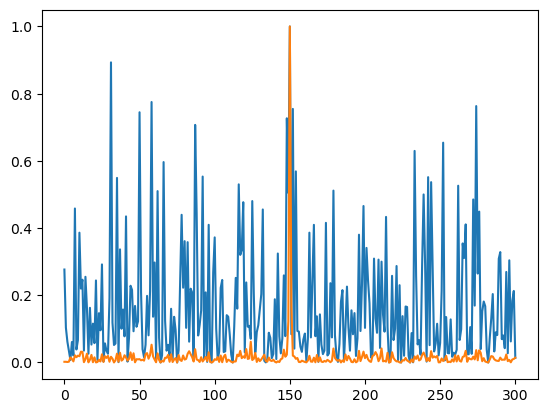

In [6]:
analyzer_gradient = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model)
a_alb0 = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a_alb0[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a_alb0[sample] /= np.max(np.abs(a_alb0[sample]))

plt.plot(a_alb0[0])
plt.plot(a_alb0[10])

2023-06-28 20:39:13.189003: W tensorflow/c/c_api.cc:291] Operation '{name:'bias_2/Assign' id:610 op device:{requested: '', assigned: ''} def:{{{node bias_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_2, bias_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:13.223705: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_5/MaxNeuronSelection_1/Max_grad/range' id:634 op device:{requested: '', assigned: ''} def:{{{node gradients_5/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_5/MaxNeuronSelection_1/Max_grad/range/start, gradients_5/MaxNeuronSelection_1/Max_grad/Size, gradients_5/MaxNeuronSelection_1/Max_grad/range/delt

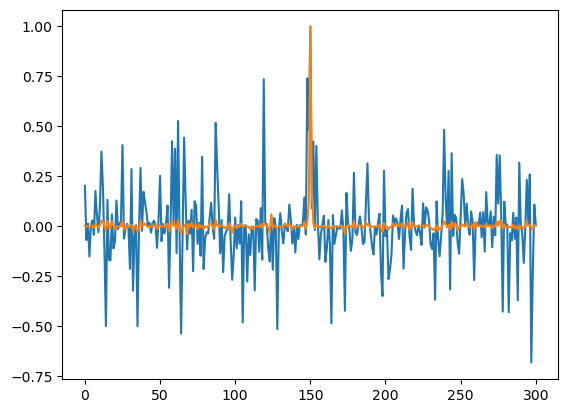

In [7]:
analyzer_gradient = innvestigate.create_analyzer("lrp.z", best_model)
a_z = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a_z[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a_z[sample] /= np.max(np.abs(a_z[sample]))

plt.plot(a_z[0])
plt.plot(a_z[10])

In [8]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref+update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                    
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    #     def getLayerIndexByName(model, layername):
    #         for idx, layer in enumerate(model.layers):
    #             if layer.name == layername:
    #                 return idx
    #         raise Exception(f"layername: {layername} not found.")
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [9]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])


y_ref, y-y_reg, y, y_reg

2023-06-28 20:39:14.796404: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:14.820129: W tensorflow/c/c_api.cc:291] Operation '{name:'count_2/Assign' id:700 op device:{requested: '', assigned: ''} def:{{{node count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_2, count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:14.855827: W tensorf

2023-06-28 20:39:15.362255: W tensorflow/c/c_api.cc:291] Operation '{name:'dense12/bias/Assign' id:829 op device:{requested: '', assigned: ''} def:{{{node dense12/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense12/bias, dense12/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:15.592740: W tensorflow/c/c_api.cc:291] Operation '{name:'add_7' id:909 op device:{requested: '', assigned: ''} def:{{{node add_7}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](add_6, dense23/MatMul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:15.6205

(array([[0.00343095]], dtype=float32),
 array([[0.0033771]], dtype=float32),
 array([[0.0068619]], dtype=float32),
 array([[0.0034848]], dtype=float32))

In [10]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])

y_ref, y-y_reg, y, y_reg

2023-06-28 20:39:15.715583: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:15.764497: W tensorflow/c/c_api.cc:291] Operation '{name:'count_5/Assign' id:1004 op device:{requested: '', assigned: ''} def:{{{node count_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_5, count_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:15.820141: W tensor

2023-06-28 20:39:16.169840: W tensorflow/c/c_api.cc:291] Operation '{name:'dense23_1/kernel/Assign' id:1208 op device:{requested: '', assigned: ''} def:{{{node dense23_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense23_1/kernel, dense23_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:16.476641: W tensorflow/c/c_api.cc:291] Operation '{name:'add_9' id:1213 op device:{requested: '', assigned: ''} def:{{{node add_9}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](add_8, dense23_1/MatMul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

(array([[0.0137238]], dtype=float32),
 array([[0.01375013]], dtype=float32),
 array([[0.0068619]], dtype=float32),
 array([[-0.00688823]], dtype=float32))

In [11]:
def triplicated_model_LRP_compatible(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model1 = keras.Model(inputs=inputs, outputs=x1)
    model2 = keras.Model(inputs=inputs, outputs=x2) 
    model3 = keras.Model(inputs=inputs, outputs=x3) 
            
    model1.layers[getLayerIndexByName(model1, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model2.layers[getLayerIndexByName(model2, 'dense12')].set_weights([-W_in, -bias_in])                 
    model3.layers[getLayerIndexByName(model3, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model1.layers[getLayerIndexByName(model1, 'dense21')].set_weights([W_out])
    model2.layers[getLayerIndexByName(model2, 'dense22')].set_weights([W_out])
    model3.layers[getLayerIndexByName(model3, 'dense23')].set_weights([-W_out])
    
    model1.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model2.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model3.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model1, model2, model3

In [12]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model1.predict(M_samples[np.newaxis, index])
y3 = model1.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-28 20:39:16.646080: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:16.675767: W tensorflow/c/c_api.cc:291] Operation '{name:'total_8/Assign' id:1303 op device:{requested: '', assigned: ''} def:{{{node total_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_8, total_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:16.717031: W tensor

2023-06-28 20:39:17.213297: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_2/MatMul' id:1436 op device:{requested: '', assigned: ''} def:{{{node dense21_2/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_2/Relu, dense21_2/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:17.254600: W tensorflow/c/c_api.cc:291] Operation '{name:'total_9/Assign' id:1510 op device:{requested: '', assigned: ''} def:{{{node total_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_9, total_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes

2023-06-28 20:39:18.531764: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_24/x' id:1990 op device:{requested: '', assigned: ''} def:{{{node mul_24/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:18.571330: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_6' id:1987 op device:{requested: '', assigned: ''} def:{{{node Const_6}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:18.616763: W tensor

2023-06-28 20:39:19.544687: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_33/x' id:2238 op device:{requested: '', assigned: ''} def:{{{node mul_33/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:19.586165: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_9' id:2235 op device:{requested: '', assigned: ''} def:{{{node Const_9}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:19.633762: W tensor

(array([[0.0068619]], dtype=float32),
 array([[0.0137238]], dtype=float32),
 array([[0.0068619]], dtype=float32))

array([[-0.01044409]])

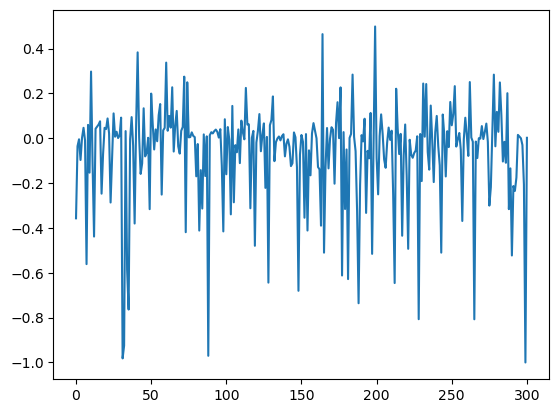

In [13]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.06245447]])

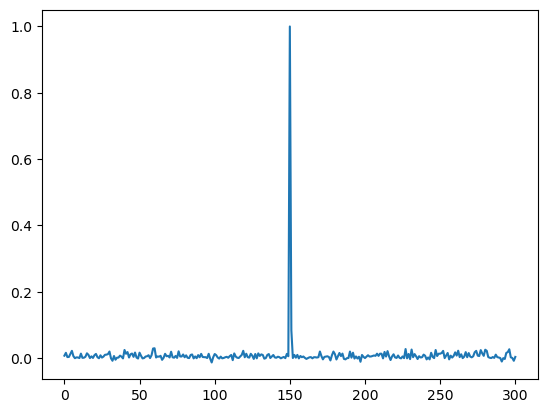

In [14]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.00254748]])

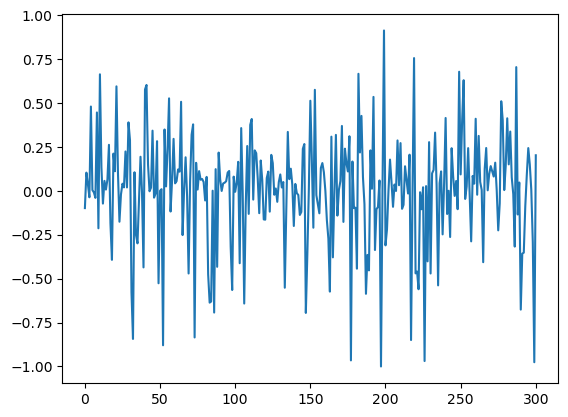

In [15]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 100
plt.plot(a[index])
H_samples[index]-y_ref

In [16]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 3.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model2.predict(M_samples[np.newaxis, index])
y3 = model3.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-28 20:39:23.173890: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:23.241380: W tensorflow/c/c_api.cc:291] Operation '{name:'count_12/Assign' id:2267 op device:{requested: '', assigned: ''} def:{{{node count_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_12, count_12/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:23.328855: W te

2023-06-28 20:39:23.612170: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13_3/bias/Assign' id:2373 op device:{requested: '', assigned: ''} def:{{{node dense13_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13_3/bias, dense13_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:24.179824: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_3/MatMul' id:2395 op device:{requested: '', assigned: ''} def:{{{node dense21_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_3/Relu, dense21_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futur

2023-06-28 20:39:25.820467: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_24/Assign' id:2900 op device:{requested: '', assigned: ''} def:{{{node kernel_24/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_24, kernel_24/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:25.902553: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_28/MaxNeuronSelection_6/Max_grad/range' id:2924 op device:{requested: '', assigned: ''} def:{{{node gradients_28/MaxNeuronSelection_6/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_6/Max"], _has_manual_control_dependencies=true](gradients_28/MaxNeuronSelection_6/Max_grad/range/start, gradients_28/MaxNeuronSelection_6/Max_grad/Size, gradients_28/Ma

2023-06-28 20:39:27.028165: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_33/MaxNeuronSelection_7/Max_grad/ones' id:3130 op device:{requested: '', assigned: ''} def:{{{node gradients_33/MaxNeuronSelection_7/Max_grad/ones}} = Fill[T=DT_INT32, _class=["loc:@MaxNeuronSelection_7/Max"], _has_manual_control_dependencies=true, index_type=DT_INT32](gradients_33/MaxNeuronSelection_7/Max_grad/Shape_1, gradients_33/MaxNeuronSelection_7/Max_grad/ones/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 20:39:27.090437: W tensorflow/c/c_api.cc:291] Operation '{name:'MaxNeuronSelection_7/Max/reduction_indices' id:3016 op device:{requested: '', assigned: ''} def:{{{node MaxNeuronSelection_7/Max/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] val

(array([[0.0068619]], dtype=float32),
 array([[0.0022873]], dtype=float32),
 array([[0.00226483]], dtype=float32))

array([[0.00099241]])

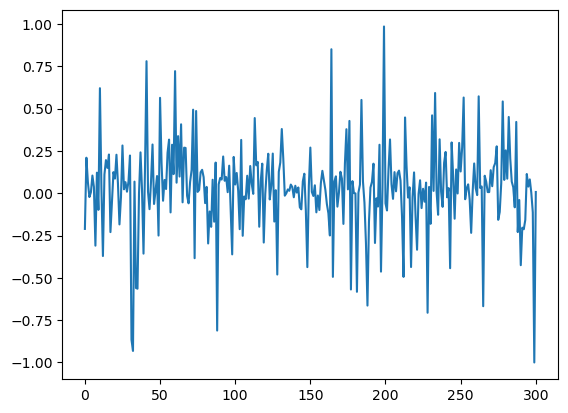

In [17]:
index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.07389097]])

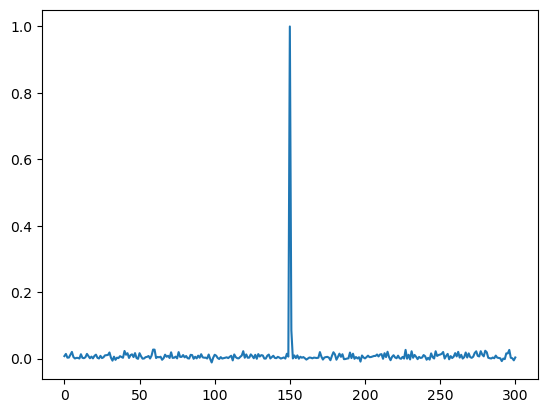

In [18]:
index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.0726358]])

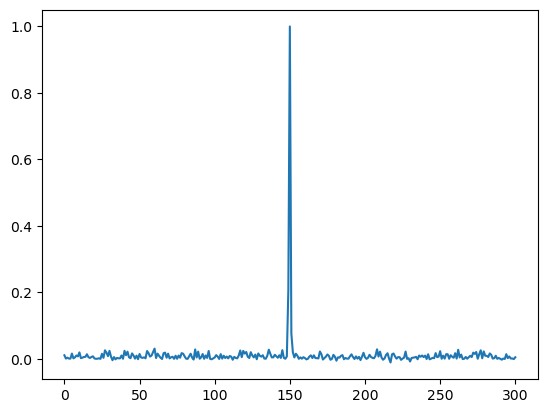

In [19]:
index = 2
plt.plot(a[index])
H_samples[index]-y_ref